1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
    
%precision 4

'%.4f'

First approach


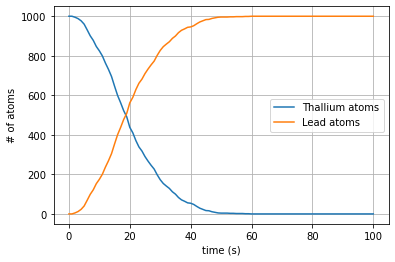

Second approach


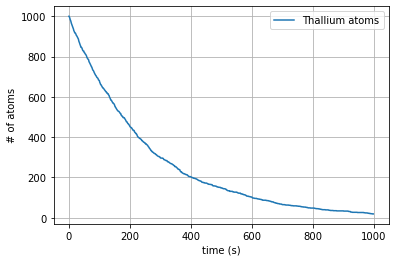

In [9]:
np.random.seed(517)

def lcg(m=2**32, a=1103515245, c=12345):
    lcg.current = (a*lcg.current + c) % m
    return lcg.current/m

# setting the seed
lcg.current = 1170828

def p (time, tau):
    return 1-2**(-time/tau)

def inv(r,tau):
    return -tau*np.log2(1-r)

print("First approach")

Tl = 1000
Pb = 0
tau = 183.12
time = 0
step = 1
N = 100

v_Tl = []
v_Pb = []
v_time = []

v_Tl.append(Tl)
v_Pb.append(Pb)
v_time.append(time)

for i in range(0,N):
    for j in range(0,Tl):
        if (lcg()<p(time,tau)):
            Tl -= 1
            Pb += 1
    time += step
    v_Tl.append(Tl)
    v_Pb.append(Pb)
    v_time.append(time)

plt.grid()
plt.ylabel("# of atoms")
plt.xlabel("time (s)") 
plt.plot(v_time, v_Tl,label="Thallium atoms")
plt.plot(v_time, v_Pb,label="Lead atoms")
plt.legend()
plt.show()


print("Second approach")

v_ran = [lcg() for i in range(1000)]
times = []
not_dec = []
x = []

for i in v_ran:
    times.append(inv(i, tau))

for i in range(0,1000,1):
    count=0
    for time in times:
        if(time>i): count += 1
    not_dec.append(count)
    x.append(i)
    
plt.grid()
plt.ylabel("# of atoms")
plt.xlabel("time (s)") 
plt.plot(x, not_dec,label="Thallium atoms")
plt.legend()
plt.show()


2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

In [11]:
def f(x):
    return (np.sin(1/(1-x)))**2

def sigma(vect,N):
    return 2*np.sqrt(np.var(vect)/N)

N = 5*10**5
count = 0
vect = []

for i in range(0,N):
    r = lcg()
    vect.append(f(r))
    x = 0+lcg()*2
    if (r<f(x)): count += 1
        
print("hit/miss method integral =",count*2*1/N)
print("err =", sigma(vect,N))

N = 10**6
I = 0
vect2 = []
x = np.random.uniform(0,2,N)

for i in x:
    vect2.append(f(i))
    I += f(i)

print("mean value method integral = ", I*2/N)

print("err=", sigma(vect2,N) )

hit/miss method integral = 1.346988
err = 0.0009246205906295026
mean value method integral =  1.3475756834416692
err= 0.0006540821066282717


3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [12]:
def n_dim_sphere(n_dim, n_samples):
    v = []
    
    for i in range(0,n_dim):
        s = [lcg() for i in range(n_samples)]
        v.append(s)
      
    count = 0
    
    for i in range (0,n_samples):
        f=0
        for dim in v:
            f += dim[i]**2
        
        if (np.sqrt(f)<1): count += 1
        
    print("hit/miss method integral for unit sphere in", n_dim, "dimensions =",count*2**n_dim/n_samples)

n_dim_sphere(2,1000000)
n_dim_sphere(10,1000000)

hit/miss method integral for unit sphere in 2 dimensions = 3.141104
hit/miss method integral for unit sphere in 10 dimensions = 2.562048


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [13]:
def w(a):
    return 1/np.sqrt(a)

def f(a):
    return(pow(a,-1/2)/(np.exp(a)+1))

N = 1000000
Iw = 2

I = 0
v = []
for i in range(N):
    x = (np.random.random())**2
    v.append(f(x)/w(x))
    I += (f(x)/w(x))
I = Iw*I/N

print("I =",I , "+-", sigma(v,N))

I = 0.8390289438060796 +- 0.00014073171206164414
